In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from functools import partial

In [2]:
!nvidia-smi

Sun Dec 27 01:54:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
train_path = '/content/drive/My Drive/project/AOI/data/'
test_path = '/content/drive/My Drive/project/AOI/data/'

In [4]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

#---------------------------------------
def decode_image(image):
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = image/255
    # image = tf.reshape(image, [224, 224, 3])
    return image

def decode_label(label):
  label = tf.io.decode_raw(label, tf.float32)
  # label = tf.cast(label, tf.float32)
  return label

def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            'image_raw': tf.io.FixedLenFeature([], tf.string),
            'target': tf.io.FixedLenFeature([], tf.string)
        }
        if labeled
        else {"image_raw": tf.io.FixedLenFeature([], tf.string)}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image_raw'])
    if labeled:
        label = decode_label(example['target'])
        # label = tf.cast(label, tf.int32)
        return image, label
    return image

def load_dataset(filenames, labeled = False):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    # ignore_order.experimental_deterministic = True # For testing
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)  
# uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled = labeled), num_parallel_calls = AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled = False):
    dataset = load_dataset(filenames, labeled = labeled)
#     dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size = AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [5]:
# train_dataset = get_dataset(os.path.join(train_path, 'train.tfrecord'), labeled = True)
test_dataset = get_dataset(os.path.join(test_path, 'test.tfrecord'), labeled = False)

In [6]:
# imge_batch, label_batch = next(iter(train_dataset))
img_batch = next(iter(test_dataset))

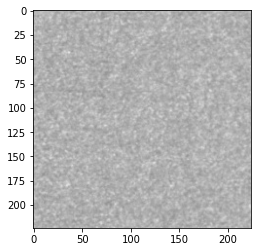

In [8]:
plt.imshow(img_batch[4])

In [5]:
model = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3), 
                                         include_top = False, 
                                         weights = 'imagenet',
                                         classes = 6, 
                                         pooling = 'None')

In [ ]:
model.summary()

In [ ]:
def make_model():
    base_model = tf.keras.applications.ResNet50V2(
        input_shape=(224, 224, 3), include_top = False, weights = 'imagenet',
        classes = 6, pooling = 'None'
    )

    base_model.trainable = True

    inputs = tf.keras.layers.Input([224, 224, 3])
    # x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # x = tf.keras.layers.Dense(8, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(6, activation = 'softmax')(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    f1_marco = tfa.metrics.F1Score(num_classes = 6, average = 'macro')
    # f1_marco = tfa.metrics.F1Score(num_classes = 5, average = 'weighted')
    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
        loss = 'categorical_crossentropy',
        metrics = f1_marco
    )

    return model

In [ ]:
my_model = make_model()
history = my_model.fit(
    train_dataset,
    epochs = 30
)

Epoch 1/30
790/790 [==============================] - 905s 1s/step - loss: 1.1375 - f1_score: 0.4400
Epoch 2/30
790/790 [==============================] - 898s 1s/step - loss: 0.5692 - f1_score: 0.6965
Epoch 3/30
790/790 [==============================] - 896s 1s/step - loss: 0.3900 - f1_score: 0.8022
Epoch 4/30
790/790 [==============================] - 897s 1s/step - loss: 0.2286 - f1_score: 0.8990
Epoch 5/30
790/790 [==============================] - 897s 1s/step - loss: 0.1651 - f1_score: 0.9259
Epoch 6/30
790/790 [==============================] - 896s 1s/step - loss: 0.1274 - f1_score: 0.9424
Epoch 7/30
790/790 [==============================] - 896s 1s/step - loss: 0.1040 - f1_score: 0.9553
Epoch 8/30
790/790 [==============================] - 895s 1s/step - loss: 0.0945 - f1_score: 0.9582
Epoch 9/30
790/790 [==============================] - 894s 1s/step - loss: 0.0754 - f1_score: 0.9648
Epoch 10/30
790/790 [==============================] - 894s 1s/step - loss: 0.0682 - f1_sco

KeyboardInterrupt: ignored

In [ ]:
my_model.save('/content/drive/My Drive/project/AOI/data/20201225.h5')

# Predict

In [7]:
model_v1 = tf.keras.models.load_model('/content/drive/My Drive/project/AOI/MODEL/20201225.h5')

In [ ]:
model_v1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 23,531,654
Non-trainable params: 45,440
_________________________________________________________________


In [9]:
predict = model_v1.predict(test_dataset)

In [13]:
l_predict = np.argmax(predict, axis = 1)
l_predict = l_predict.reshape((len(l_predict), 1))
test = np.array(pd.read_csv(os.path.join(test_path, 'test.csv')))
test_name = test[:, 0]
test_name = test_name.reshape((len(test_name), 1))
result = np.concatenate((test_name, l_predict), axis = 1)
summit = pd.DataFrame(result, columns = ['ID', 'Label'])
summit.to_csv('/content/drive/My Drive/project/AOI/summit/second_time.csv')